In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
import numpy
import cv2
from tensorflow.keras.preprocessing import image

2025-04-25 17:16:40.597404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 17:16:40.604345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 17:16:40.663131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 17:16:40.725407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745612200.782877   34160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745612200.79

In [2]:
"""
Reading labels and balancing dataframe
"""

df_labels = pd.read_csv("../../dataset/labels.csv")

df_label_0 = df_labels[df_labels["state"] == 0]
df_label_1 = df_labels[df_labels["state"] == 1]

min_size = len(df_label_1)
df_label_0_balanced = df_label_0.sample(n=min_size, random_state=42)

df_balanced = pd.concat([df_label_1, df_label_0_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced["state"] = df_balanced["state"].astype(str)

In [3]:
"""
Variables for the model and the ImageDataGenerator object
"""

data_path = "../../dataset/spots-uncropped-uniform/"
batch_size = 1000
img_size = (40, 40)

In [4]:
"""
Creating the tensorflow dataset and
creating training, validation and testing splits
"""

df_train, df_temp = train_test_split(df_balanced, test_size=0.4, random_state=42)
df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=data_path,
    x_col="image_name",
    y_col="state",
    class_mode="binary",
    target_size=img_size,
    batch_size=batch_size,
    # subset="training"
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_validation,
    directory=data_path,
    x_col="image_name",
    y_col="state",
    class_mode="binary",
    target_size=img_size,
    batch_size=batch_size,
    # subset="validation"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=data_path,
    x_col="image_name",
    y_col="state",
    class_mode="binary",
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 16400 validated image filenames belonging to 2 classes.
Found 5467 validated image filenames belonging to 2 classes.
Found 5467 validated image filenames belonging to 2 classes.


In [5]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [6]:
def square_activation(x):
    return tf.math.square(x)

In [7]:
def print_model_weights(model):
    numpy.set_printoptions(threshold=sys.maxsize)
    model_weights = model.get_weights()

    for i, layer_weights in enumerate(model_weights):
        print(f"Layer {i // 2 + i} {'weights' if i % 2 == 0 else 'biases'}: {layer_weights.shape}")
        for val in layer_weights:
            print('{:8f}'.format(val[0]), end=" ")

In [8]:
def save_model_weights(model):
    numpy.set_printoptions(threshold=sys.maxsize)
    model_weights = model.get_weights()

    i = 0
    with open("./weights.txt", 'a') as file:
        for layer_weights in model_weights:
            for val in layer_weights:
                i += 1
                if i != 6:
                    file.write('{:8f}, '.format(val[0]))
                else:
                    file.write('{:8f}, \n'.format(val[0]))
                    i = 0

# --- FIRST ATTEMPTS / MODELS ---

In [8]:
model_big = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(40, 40, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

/home/pedro/uni/ic/nn-test/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-15 19:55:01.546738: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
model_big.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_big.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 38, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,529 (588.00 KB)

 Trainable params: 150,529 (588.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history_big = model_big.fit(train_generator, epochs=7, validation_data=validation_generator)

/home/pedro/uni/ic/nn-test/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 628ms/step - accuracy: 0.7044 - loss: 0.5608 - val_accuracy: 0.9276 - val_loss: 0.2238
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9332 - loss: 0.1946 - val_accuracy: 0.9568 - val_loss: 0.1079
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.9576 - loss: 0.1117 - val_accuracy: 0.9755 - val_loss: 0.0772
Epoch 4/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.9807 - loss: 0.0727 - val_accuracy: 0.9850 - val_loss: 0.0540
Epoch 5/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.9846 - loss: 0.0575 - val_accuracy: 0.9932 - val_loss: 0.0413
Epoch 6/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.9903 - loss: 0.0418 - val_accuracy: 0.9940 - val_loss: 0.0333
Epoch 7/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.9932 - loss: 0.0336 - val_accuracy: 0.9932 - val_loss: 0.0322


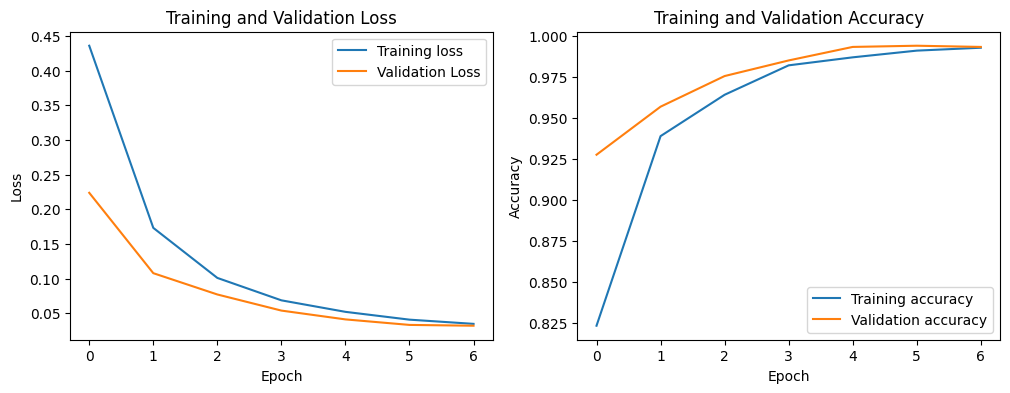

In [11]:
plot_history(history_big)

In [12]:
model_small = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation="relu"),

    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [13]:
model_small.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_small.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_small = model_small.fit(train_generator, epochs=8, validation_data=validation_generator)

Epoch 1/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.5455 - loss: 0.6656 - val_accuracy: 0.7684 - val_loss: 0.5368
Epoch 2/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.8853 - loss: 0.4656 - val_accuracy: 0.9376 - val_loss: 0.2274
Epoch 3/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9411 - loss: 0.2138 - val_accuracy: 0.9570 - val_loss: 0.1295
Epoch 4/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9627 - loss: 0.1137 - val_accuracy: 0.9791 - val_loss: 0.0760
Epoch 5/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9820 - loss: 0.0721 - val_accuracy: 0.9881 - val_loss: 0.0527
Epoch 6/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9875 - loss: 0.0538 - val_accuracy: 0.9892 - val_loss: 0.0430
Epoch 7/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9897 - loss: 0.0412 - val_accuracy: 0.9930 - val_loss: 0.0344
Epoch 8/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9903 - v

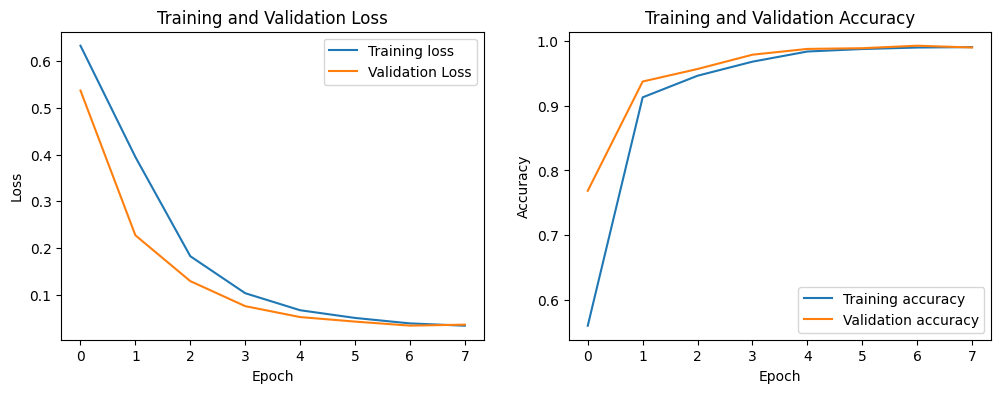

In [15]:
plot_history(history_small)

In [16]:
model_small_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [17]:
model_small_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_small_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_small_2 = model_small_2.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.5099 - loss: 0.6448 - val_accuracy: 0.6936 - val_loss: 0.5264
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7433 - loss: 0.5004 - val_accuracy: 0.8886 - val_loss: 0.4121
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9153 - loss: 0.4102 - val_accuracy: 0.9577 - val_loss: 0.3742
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9508 - loss: 0.3765 - val_accuracy: 0.9576 - val_loss: 0.3536
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9696 - loss: 0.3627 - val_accuracy: 0.9678 - val_loss: 0.3411
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9809 - loss: 0.3045 - val_accuracy: 0.9828 - val_loss: 0.1189
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9806 - loss: 0.1024 - val_accuracy: 0.9923 - val_loss: 0.0591
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9898 - loss: 0.0582 - val_accuracy: 0.

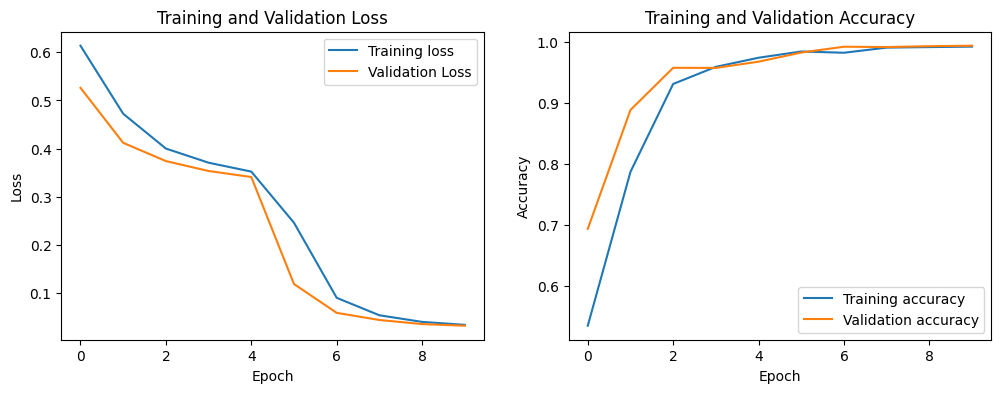

In [19]:
plot_history(history_small_2)

In [20]:
model_small_without_convolution = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [21]:
model_small_without_convolution.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_small_without_convolution.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.6663 - loss: 0.5569 - val_accuracy: 0.8299 - val_loss: 0.3280
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8870 - loss: 0.3093 - val_accuracy: 0.9444 - val_loss: 0.2324
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9441 - loss: 0.2208 - val_accuracy: 0.9576 - val_loss: 0.1807
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9613 - loss: 0.1751 - val_accuracy: 0.9652 - val_loss: 0.1438
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9691 - loss: 0.1422 - val_accuracy: 0.9768 - val_loss: 0.1220
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9774 - loss: 0.1224 - val_accuracy: 0.9782 - val_loss: 0.1062
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9794 - loss: 0.1060 - val_accuracy: 0.9790 - val_loss: 0.0941
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9817 - loss: 0.0945 - val_accuracy: 0.

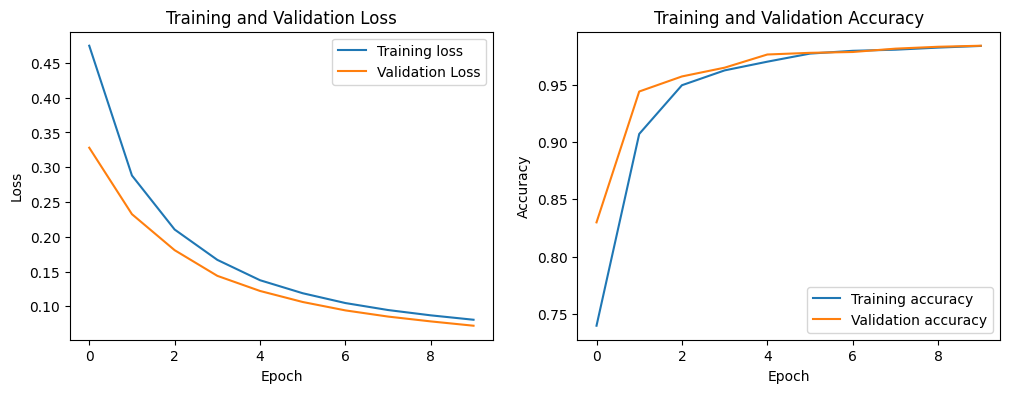

In [22]:
history_small_without_convolution = model_small_without_convolution.fit(train_generator, epochs=10, validation_data=validation_generator)

plot_history(history_small_without_convolution)

In [23]:
model_square = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation=square_activation),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [24]:
model_square.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_square.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5310 - loss: 1.0318 - val_accuracy: 0.6490 - val_loss: 0.6459
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7620 - loss: 0.5007 - val_accuracy: 0.8496 - val_loss: 0.3201
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8525 - loss: 0.3223 - val_accuracy: 0.8818 - val_loss: 0.2688
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8854 - loss: 0.2580 - val_accuracy: 0.9356 - val_loss: 0.2065
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9378 - loss: 0.2192 - val_accuracy: 0.9620 - val_loss: 0.1583
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9699 - loss: 0.1610 - val_accuracy: 0.9779 - val_loss: 0.1291
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9807 - loss: 0.1366 - val_accuracy: 0.9821 - val_loss: 0.1037
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9815 - loss: 0.1297 - val_accuracy: 0.

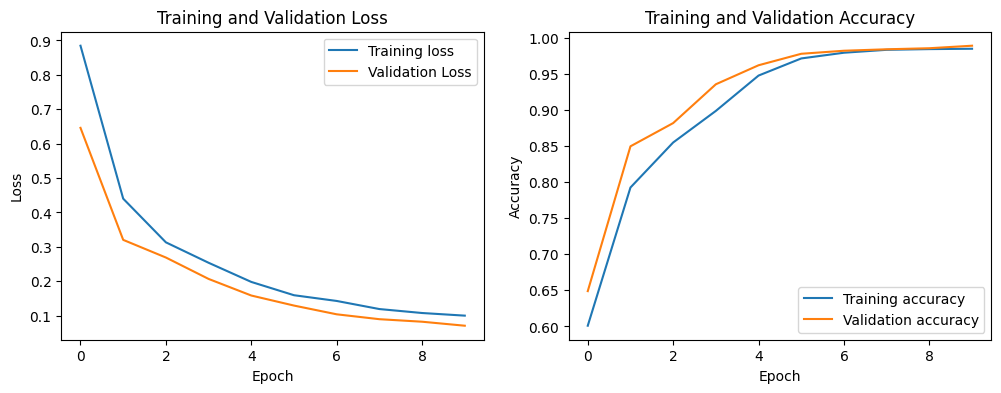

In [25]:
history_square = model_square.fit(train_generator, epochs=10, validation_data=validation_generator)

plot_history(history_square)

In [26]:
model_square.fit(test_generator, epochs=3)

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9882 - loss: 0.0684
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9874 - loss: 0.0706
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9897 - loss: 0.0627


# Model Only Sigmoid

2025-04-25 17:16:49.928789: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pedro/uni/ic/nn-test/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.5966 - loss: 0.6769 - val_accuracy: 0.7960 - val_loss: 0.4356
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7818 - loss: 0.4192 - val_accuracy: 0.7960 - val_loss: 0.3602
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8160 - loss: 0.3609 - val_accuracy: 0.8829 - val_loss: 0.3115
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8881 - loss: 0.3132 - val_accuracy: 0.9144 - val_loss: 0.2741
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9229 - loss: 0.2723 - val_accuracy: 0.9389 - val_loss: 0.2454
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9399 - loss: 0.2458 - val_accuracy: 0.9506 - val_loss: 0.2217
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9511 - loss: 0.2237 - val_accuracy: 0.9577 - val_loss: 0.2027
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9576 - loss: 0.2100 - val_accuracy: 0.

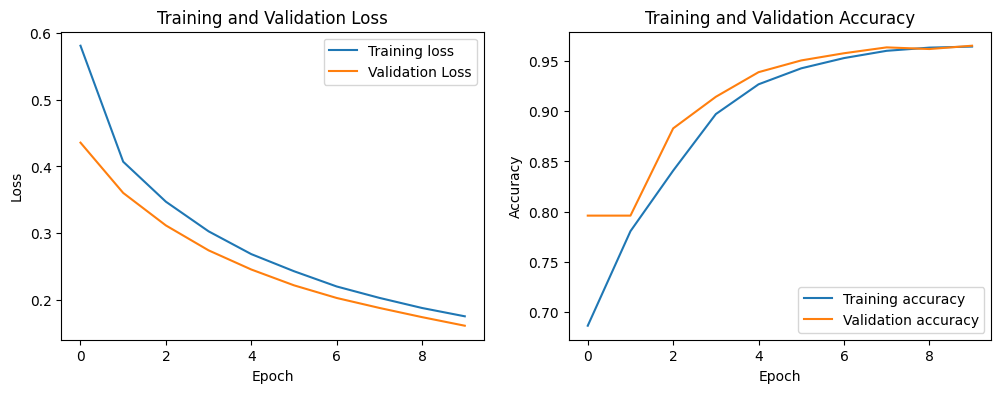

In [9]:
"""
DEFINING AND TRAINING MODEL
"""

model_only_sigmoid = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_only_sigmoid.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_only_sigmoid = model_only_sigmoid.fit(train_generator, epochs=10, validation_data=validation_generator)

plot_history(history_only_sigmoid)

In [10]:
"""
OUTPUTING ARCHITECTURE
"""

model_only_sigmoid_weights = model_only_sigmoid.get_weights()

# Configuring numpy such that the output of the cell 
# doesn't truncate
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

for i, layer_weights in enumerate(model_only_sigmoid_weights):
    print(f"Layer {i // 2 + i} {'weights' if i % 2 == 0 else 'biases'}: {layer_weights.shape}")
    for arr in layer_weights:
        if arr > 0.13 or arr < -0.13:
            print(arr)

Layer 0 weights: (4800, 1)
Layer 1 biases: (1,)


In [12]:
save_model_weights(model_only_sigmoid)

IndexError: invalid index to scalar variable.

In [ ]:
"""
MANUALLY TESTING ACCURACY FOR EXTERNAL DATASET
"""

img_timer_test_path = "..././dataset/external-dataset/"
for i in range(62):
    img_path = img_timer_test_path + f"crop{str(i)}.jpg"
    img = image.load_img(img_path, target_size=(40, 40, 3))

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictionstemp = model_only_sigmoid.predict(img_array)
    if (predictionstemp > 0.5):
        pred = 1
    else:
        pred = 0
    print(f"Prediction for image {i} = {pred}")


In [ ]:
"""
MANUALLY CALCULATING INFERENCE
"""
import cv2

dense_layer = model_only_sigmoid.layers[1]
weights, bias = dense_layer.get_weights()

image = cv2.imread("../../dataset/test-ocuppied.png")
image = image.flatten()
image = [(np.float64(a) / 255.0) for a in image]
print(image)
# inverting opencvs strange BGR format
nimage = []
for i in range(0, len(image), 3):
    nimage.extend([image[i + 2], image[i + 1], image[i]])
print(nimage)

output = np.dot(nimage, weights) + bias
output = 1/(1 + np.exp(-output))
output

# Model X² -> Sigmoid

In [ ]:
model_x2_sig =  tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation=square_activation),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_x2_sig.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_final = model_x2_sig.fit(train_generator, epochs=10, validation_data=validation_generator)

plot_history(history_final)

In [ ]:
from tensorflow.keras.preprocessing import image

img_timer_test_path = "../../dataset/external-dataset/"
for i in range(62):
    img_path = img_timer_test_path + f"crop{str(i)}.jpg"
    img = image.load_img(img_path, target_size=(40, 40, 3))

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictionstemp = model_x2_sig.predict(img_array)
    if (predictionstemp > 0.5):
        pred = 1
    else:
        pred = 0
    print(f"Prediction for image {i} = {pred}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


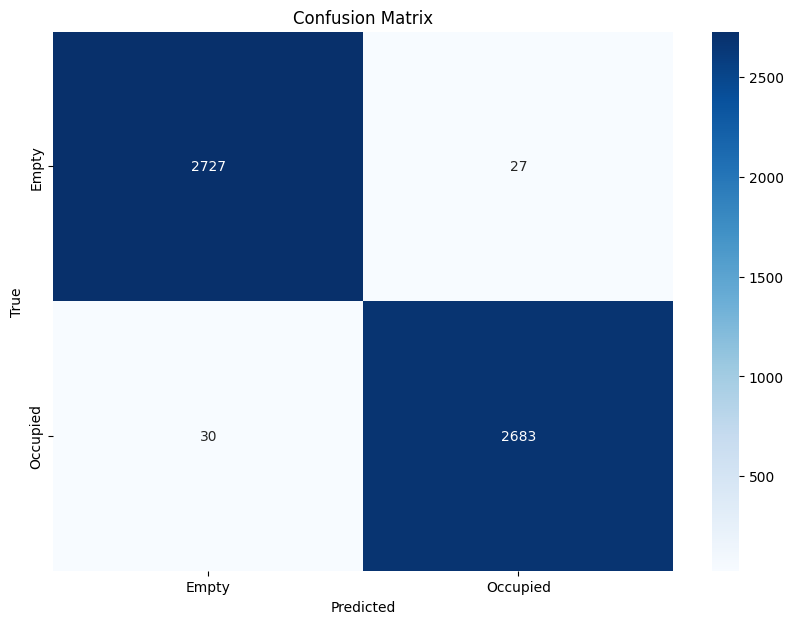

In [ ]:
# Make predictions on the validation set
predictions = model_x2_sig.predict(test_generator)
predicted_classes = np.round(predictions).astype(int).flatten()

# Get true labels from the validation generator
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Empty', 'Occupied'], yticklabels=['Empty', 'Occupied'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print_model_weights(model_x2_sig)